<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Different-Prior-distribution-vs-Different-number-of-experiments" data-toc-modified-id="Different-Prior-distribution-vs-Different-number-of-experiments-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Different Prior distribution vs Different number of experiments</a></span></li><li><span><a href="#Grid-search-method-for-basic-coin-tosses-problem" data-toc-modified-id="Grid-search-method-for-basic-coin-tosses-problem-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Grid search method for basic coin tosses problem</a></span></li><li><span><a href="#MCMC-and-pymc3-to-solve-coin-tosses" data-toc-modified-id="MCMC-and-pymc3-to-solve-coin-tosses-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>MCMC and pymc3 to solve coin tosses</a></span><ul class="toc-item"><li><span><a href="#Gelman-Rubin-test-for-convergence,-and-other-evaluation" data-toc-modified-id="Gelman-Rubin-test-for-convergence,-and-other-evaluation-3.1"><span class="toc-item-num">3.1&nbsp;&nbsp;</span>Gelman-Rubin test for convergence, and other evaluation</a></span></li></ul></li></ul></div>

In [5]:
%matplotlib inline
     
import pymc3 as pm 

import numpy as np
import matplotlib.pyplot as plt
from scipy import stats

## Different Prior distribution vs Different number of experiments
- Prior can have very different effect if number of experiments are low
- If a lot exp, then prior don't really matter

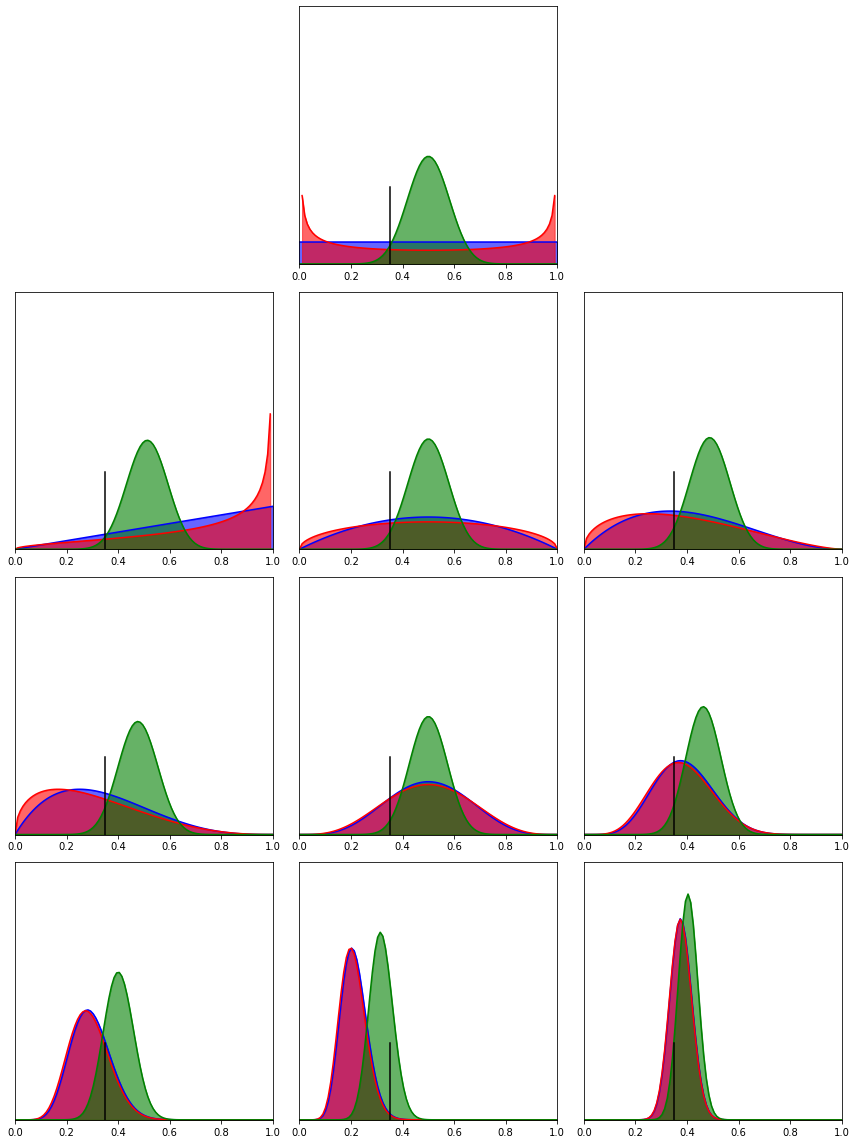

In [2]:
theta_real = 0.35
trials = [0, 1, 2, 3, 4, 8, 16, 32, 64, 128]
data = [0, 1, 1, 1, 1, 4, 6, 9, 13, 48]

beta_params = [(1, 1), (0.5, 0.5), (20, 20)]
dist = stats.beta
x=np.linspace(0, 1, 100)
plt.figure(figsize=(12, 16))

for idx, N in enumerate(trials):
    if idx == 0:
        plt.subplot(4, 3, 2)
    else:
        plt.subplot(4, 3, idx+3)
    y = data[idx]
    for (a_prior, b_prior), c in zip(beta_params, ('b', 'r', 'g')):
        p_theta_given_y = dist.pdf(x, a_prior + y, b_prior + N - y)
        plt.plot(x, p_theta_given_y, c)
        plt.fill_between(x, 0, p_theta_given_y, color=c, alpha=0.6)
        
    plt.axvline(theta_real, ymax=0.3, color='k')
    plt.xlim(0, 1)
    plt.ylim(0, 12)
    plt.gca().axes.get_yaxis().set_visible(False)
plt.tight_layout()


## Grid search method for basic coin tosses problem


In [3]:
def posterior_grid(grid_points=100, heads=6, tosses=9):
    grid = np.linspace(0, 1, grid_points)
    prior = np.repeat(1, grid_points)  # this is just uniform distribution prior
    
    # pdf is for continuous dist, pmf for discontinous
    likelihood = stats.binom.pmf(heads, tosses, grid)  # binomial distribution and based on prior
    
    unstd_posterior = likelihood * prior  # posterior
    posterior = unstd_posterior / unstd_posterior.sum()  # normalize posterior
    return grid, posterior

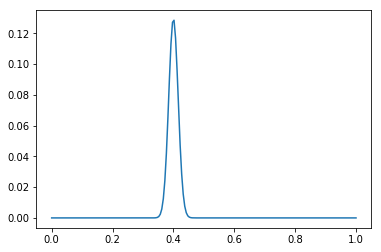

In [4]:
points = 200
h, n = 400, 1000
grid, posterior = posterior_grid(points, h, n)
plt.plot(grid, posterior)

## MCMC and pymc3 to solve coin tosses

In [29]:
np.random.seed(123)
n_experiments = 200
theta_real = 0.35
data = stats.bernoulli.rvs(p=theta_real, size=n_experiments)

with pm.Model() as our_first_model:
    theta = pm.Beta('theta', alpha=1, beta=1)
    y = pm.Bernoulli('y', p=theta, observed=data)
    step = pm.Metropolis()
    trace = pm.sample(1000, step=step, start=None)

INFO (theano.gof.compilelock): Refreshing lock /Users/hq/.theano/compiledir_Darwin-18.2.0-x86_64-i386-64bit-i386-3.7.1-64/lock_dir/lock
Multiprocess sampling (4 chains in 4 jobs)
Metropolis: [theta]
Sampling 4 chains: 100%|██████████| 6000/6000 [00:00<00:00, 8180.95draws/s]
The number of effective samples is smaller than 25% for some parameters.


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x1c213da2b0>,
      dtype=object)

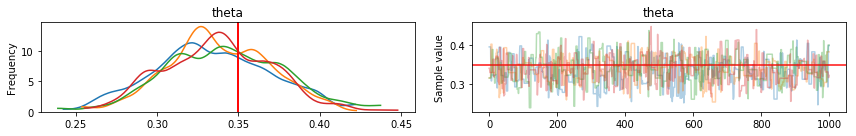

In [30]:
pm.traceplot(trace, lines={'theta': theta_real})

### Gelman-Rubin test for convergence, and other evaluation

In [31]:
pm.gelman_rubin(trace)

{'theta': 1.00410148097899}

GridSpec(1, 2, width_ratios=[3, 1])

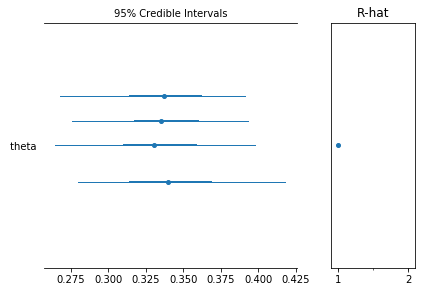

In [32]:
pm.forestplot(trace, varnames=['theta'])

In [33]:
pm.summary(trace)

,mean,sd,mc_error,hpd_2.5,hpd_97.5,n_eff,Rhat
theta,0.337372,0.034222,0.001236,0.274524,0.40577,619.533477,1.004101


$$MC_{error} = \frac{\sigma(x)}{\sqrt{n}}$$ 
- This is an estimation of the error introduced by the sampling method. 
- The estimation takes into account that the samples are not truly independent of each other.
- Should be much lower then sd

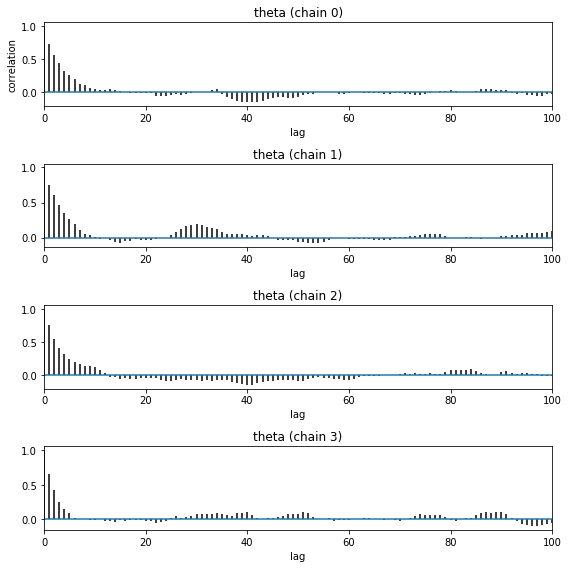

In [39]:
fig, axes = plt.subplots(nrows=4, figsize=(8, 8))
pm.autocorrplot(trace, ax=axes.reshape(1, 4))
fig.tight_layout()

In [40]:
pm.effective_n(trace)

{'theta': 619.5334773189101}

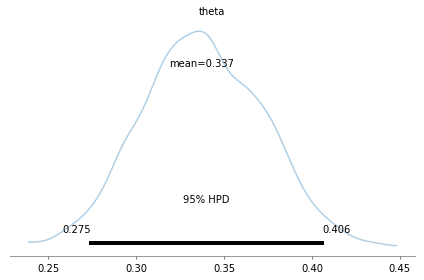

In [42]:
pm.plot_posterior(trace, kde_plot=True)